# Super-Tensor Simulation

Simulation of a quantum program involves encoding the state of the system and encoding operators that update the state according to the desired operation.

In *closed* quantum systems, we can encode our state in a *state vector* and our operations as *unitary matrices*. For a given bloq, we can query these objects with the `Bloq.tensor_contract()` method. Bloqs with only right registers correspond to states; and bloqs with thru registers correspond to unitary matrices. The tensor simulation protocol handles composing the states and unitaries to get e.g. the final state or unitary.

In *open* quantum systems, the state of our system is (potentially) a classically-probabalistic mixture over pure states (which are the states found in closed quantum systems). The operations map this mixture of states to a new mixture of states. The superoperator tensor protocol lets you simulate Qualtran programs that include non-unitary operations like measurement or discarding qubits. Any pure state can also be simulated using this protocol, but it is more expensive than the normal tensor simulation protocol; so we encourage you to use the ordinary tensor contraction protocol wherever feasible.


## Density matrix

In this section, we contract all bloqs to thier `numpy.ndarray` numerical representation. There are more indices and fewer conventions about the arrangement of these indices, so practitioners must either pay close attention to the following documentation, or deal exclusively and directly with the Quimb `qtn.TensorNetwork` objects and their named indices (see the next section).

When dealing with open system simulation, the state of the system is no longer represented by a 1-dimensional vector of probability amplitudes, but rather **a 2-dimensional matrix** of classical probabilities along the diagonal and quantum *coherences* off-diagonal.


### The $|+\rangle$ state
First, let's inspect the statevector and density matrix representation of the $|+\rangle$ state.

In [1]:
# Ordinary statevector of |+>
from qualtran.bloqs.basic_gates import PlusState
PlusState().tensor_contract()

array([0.70710678+0.j, 0.70710678+0.j])

In [2]:
# Use the superoperator simulation machinery. States are
# now density _matrices_. 
PlusState().tensor_contract(superoperator=True)

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

### Incoherent states

We know that the $|+\rangle$ state has a 50% chance of being measured in the 0 vs. 1 state. What is the difference between this and a classical coin flip? We'll compare the density matrices between the coherent `PlusState` vs. measuring the result.

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

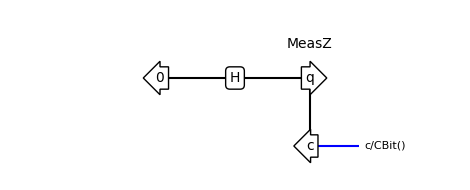

In [3]:
from qualtran import BloqBuilder
from qualtran.drawing import show_bloq
from qualtran.bloqs.basic_gates import ZeroState, Hadamard, MeasZ

# Initialize a qubit, do a Hadamard
bb = BloqBuilder()
q = bb.add(ZeroState())
q = bb.add(Hadamard(), q=q)
c = bb.add(MeasZ(), q=q)
coin_flip = bb.finalize(c=c)

# The circuit
show_bloq(coin_flip, 'musical_score')

# Its density matrix
rho_coin_flip = coin_flip.tensor_contract(superoperator=True)
display(rho_coin_flip)

## Superoperator evolution with matrix-vector multiplication

Under the hood, the Quimb tensor network package can find efficient contraction orderings for performing superoperator simulation. However, for clarity we can show how the superoperator tensors can be manipulated to evolve a vector representation of the density operator with a matrix representation of the superoperator.

### Superoperator tensors

Operations (like `Hadamard` below) are encoded in 4-index tensors. You saw above that states are encoded in 2-index tensors (the density matrix).

In [4]:
super_h = Hadamard().tensor_contract(superoperator=True)
super_h.shape

(2, 2, 2, 2)

In [5]:
rho_coin_flip.shape

(2, 2)

There is no standard naming scheme for these four indices, but we describe them here:

 - Unitary operations in standard, statevector evolution have two indices (i.e. they are matrices). We name the two indices **left** and **right** indices, corresponding to the input and output (resp.) basis states.
 - The density matrix $\rho$ for a pure state $|\psi\rangle$ is given by $|\psi\rangle \langle \psi|$.
 - Evolution of a pure state by a unitary $U$ corresponds to applying $U|\psi\rangle$ to the first part of $\rho$ and  $\langle \psi | U^\dagger$ to the latter part.
 - With a bit of poetic license, we call the indices of the $|\psi\rangle$ part the **forward** indices and the $\langle \psi|$ part the **backward** indices.

The Qualtran ordering of the superoperator tensor is:

    (right_forward, right_backward, left_forward, left_backward)

The ordering of the density matrix indices is the familiar, textbook ordering which&mdash;following the terminoligy we set up&mdash;is either

    (right_forward, right_backward)
    *or*
    (left_foward, left_backward)

depending on whether it is an initializing state or de-allocating state, respectively.

### Reshaping

The index ordering allows reshaping of superoperators into matrices and density matrices into vectors so evolution can be computed by the traditional matrix-vector product.

We'll see that applying a reshaped tensor of `Hadamard` to our reshaped `rho_coin_flip` gives us a random result, but applying it to a coherent state results in a deterministic output.

In [6]:
# Applying H to our incoherent, coin-flip state
(super_h.reshape(4,4) @ rho_coin_flip.reshape(4)).reshape(2,2)

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

In [7]:
# Applying H to our coherent state
rho_coherent = PlusState().tensor_contract(superoperator=True)
(super_h.reshape(4,4) @ rho_coherent.reshape(4)).reshape(2,2)

array([[ 1.00000000e+00+0.j,  0.00000000e+00+0.j],
       [-2.46519033e-32+0.j,  0.00000000e+00+0.j]])

## Quimb Tensor Network

The function `cbloq_to_superquimb` returns a `qtn.TensorNetwork` representing the composite bloq. The structure is apparent: there are effectively two pure-state evolutions occuring ('forward' and 'backward'). Non-unitary operations introduce an index coupling the forward and backward evolutions.

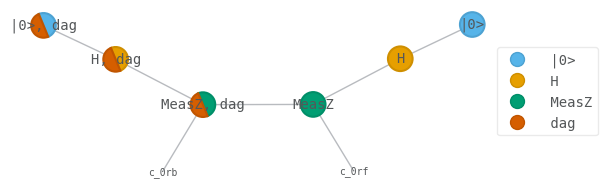

In [8]:
from qualtran.simulation.tensor import cbloq_to_superquimb
tn = cbloq_to_superquimb(coin_flip, friendly_indices=True)
tn.draw(color=['|0>', 'H', 'MeasZ', 'dag'])

## System+Environment modeling

All CPTP maps can be implemented by unitary evolution in a larger "system + environment" space. In this section, we show how to build a measurement operation with only standard, unitary bloqs and the ability to discard information.

Any Hermitian operator can be "measured" into a fresh ancilla using a simple prescription, see e.g. Nielsen and Chuang Exercise 4.44. We build that construction below.

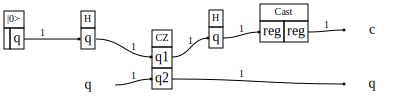

In [9]:
from qualtran import BloqBuilder, Register, Side, CtrlSpec, QBit, CBit
from qualtran.bloqs.basic_gates import ZeroState, Hadamard, MeasZ, ZGate
from qualtran.bloqs.bookkeeping import Cast

bb = BloqBuilder()
# Take a single qubit as input
q = bb.add_register(Register("q", QBit()))
# Set up our output register: we'll return one classical bit
bb.add_register(Register("c", CBit(), side=Side.RIGHT))

# This construction works for any Hermitian operator. We'll
# use Z as a familiar first example.
op = ZGate()

# Allocate space to record the result of our measurement operation
meas_space = bb.add(ZeroState())
meas_space = bb.add(Hadamard(), q=meas_space)

# Do Controlled(op)
_, add_ctrled = op.get_ctrl_system(CtrlSpec())
(meas_space,), (q,) = add_ctrled(bb, ctrl_soqs=[meas_space], in_soqs={'q': q})

# Final Hadamard, and cast our measurement register
# into a classical bit.
meas_space = bb.add(Hadamard(), q=meas_space)
meas_result = bb.add(Cast(QBit(), CBit(), allow_quantum_to_classical=True), reg=meas_space)
meas_cbloq = bb.finalize(c = meas_result, q=q)
show_bloq(meas_cbloq)

Note that we've entangled our system "q" with a fresh register. We've used a `Cast` operation to denote that the new bit is a classical bit. Practically this means we can no longer perform quantum operations like `Hadamard` to it, and any classical processing can happen on ordinary CPUs. But at a quantum-information level, there is nothing about the tensor structure to show that "c" is a 'classical' index. Below, we draw the tensor network encoding of the State/Unitary composite bloq using the ordinary tensor protocol

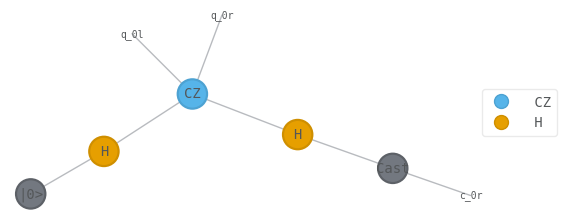

Tensor(shape=(2, 2, 2), inds=('q_0r', 'q_0l', 'c_0r'), tags=oset(['|0>', 'H', 'CZ', 'Cast']))

In [10]:
from qualtran.simulation.tensor import cbloq_to_quimb
tn = cbloq_to_quimb(meas_cbloq, friendly_indices=True)
tn.draw(color=['CZ', 'H'])
display(tn.contract())

### Making a measurement operation

In an open system&mdash;like the world we live in&mdash;we don't have coherent access to each (qu)bit worth of information. Our measurement apparatus might have $10^{23}$ particles, each recording the result of a measurement. We can simulate the standard measurement channel where information is lost to the environment by using the previous circuit and discarding the coherent qubit wire. Now, the signature of our composite bloq takes in one `QBit()` and returns one `CBit()`.

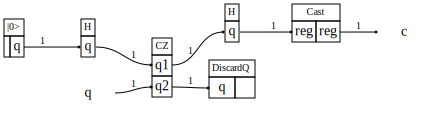

In [11]:
from qualtran.bloqs.basic_gates import DiscardQ

bb = BloqBuilder()
q = bb.add_register(Register("q", QBit(), side=Side.LEFT))
q, c = bb.add_from(meas_cbloq, q=q)
bb.add(DiscardQ(), q=q)
meas2_cbloq = bb.finalize(c=c)
show_bloq(meas2_cbloq)

The ordinary tensor simulation protocol is insufficient to handle discarding a qubit. 

In [12]:
try:
    tn = cbloq_to_quimb(meas2_cbloq, friendly_indices=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: During tensor simulation, DiscardQ tried to discard information. This requires using `tensor_contract(superoperator=True)` or `cbloq_to_superquimb`.


To remove a qubit, we need to sum over its possible states as we would when computing a marginal probability distribution. But our probability *amplitudes* only sum to 1 when we consider their absolute value squared
$$
\sum a^* a = 1,
$$
so our integration proceedure requires indexing into both our state $|\psi\rangle$ and its adjoint $\langle \psi|$ to remove the offending bit.

If you're using a densitry matrix, this correspond to performing a parital trace. In Qualtran, the superoperator tensor simulation protocol sets up two simultaneous tensor networks for simulating unitary action on the circuit *and* its adjoint. That is, we simulate both $|\psi\rangle$ and $\langle \psi|$.  Discarding a qubit is performed by contracting the qubit's index in the forward network with its corresponding index in the backwards, adjoint network.

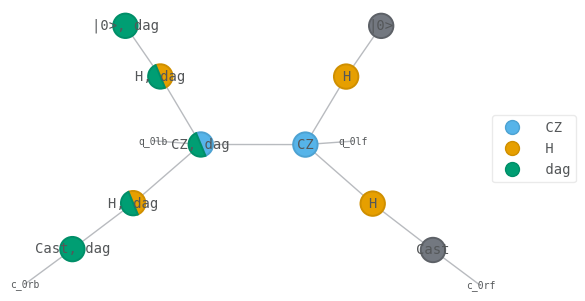

(2, 2, 2, 2)

In [13]:
tn = cbloq_to_superquimb(meas2_cbloq, friendly_indices=True)
tn.draw(color=['CZ', 'H', 'dag'], initial_layout='spectral')
display(tn.shape)

The discard operation couples the two pure evolutions. The superoperator is now a rank-4 tensor.

By the Stinespring dilation theorem, we can actually represent any superoperator (aka quantum channel, aka CPTP map) with only pure state evolution and the ability to discard qubits. This gives rise to the "System-Environment" representation of superoperators, which is the native representation in Qualtran. It is quite natural for the open-system operations we're most concerned with (like measurement); but practitioners may have to do some careful translation to encode superoperators traditionally expressed in another representation like the operator-sum (Kraus operator) representation.

## Implementation

The super-tensor protocol is a superset of the ordinary tensor simulation protocol. Bloqs override the same method to define their tensors for open-system simulation: the bloq author overrides `Bloq.my_tensors` and is responsible for returning a list of tensors whose indices follow the same prescribed format as documented in the [tensor protocol](.). 

All additional functionality is unlocked by the ability to return a `qualtran.simulation.tensor.DiscardInd` object amongst the ordinary `qtn.Tensor` objects. Per above, any superoperator can be expressed in this system-environment representation. This simple sentinel object flags the named index as subject to "tracing out" during construction of the complete network.

When calling `cbloq_to_quimb` the indices are faithfully kept as `(cxn: Connection, j: int)` tuples. During the conversion to the superoperator tensor network, each tensor returned by `Bloq.my_tensors` is added twice:
 - The 'forward' tensor is added. Its indices `(cxn, j)` are transformed to `(cxn, j, True)`
 - The 'backward' tensor is added. Its indices `(cxn, j)` are transformed to `(cxn, j, False)` and we take the element-wise complex conjugate of its data ndarray.
 - A `DiscardInd` will remove the booleans from the named index in tensors which have already been added. This causes the forward and backward indices to be contracted together.

Note that index permutation operations like taking the transpose of the backwards tensor is handled by the structure of the tensor network rather than mutating the data ndarray. 

The `my_tensors` override must order its return values such that a `DiscardInd` is encountered *after* the tensor that defines the index to discard. 